In [1]:
!git clone https://github.com/churchlab/AAV_fitness_landscape.git

Cloning into 'AAV_fitness_landscape'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 98 (delta 16), reused 29 (delta 14), pack-reused 63
Unpacking objects: 100% (98/98), done.


In [2]:
%cd /content/AAV_fitness_landscape/x02_analysis/

/content/AAV_fitness_landscape/x02_analysis


In [3]:
!pip install biopython scipy

     |████████████████████████████████| 2.3 MB 13.9 MB/s 


In [4]:
!cp ../settings/*.py .
!cp ../x01_process_data/*.py .

import os 
import sys 

from Bio import AlignIO
import pandas as pd 
pd_idx =pd.IndexSlice
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pearsonr

from common import mm_to_inch,load_axis_contacts
from common import DESIRED_AA_ORD
from common import codon_to_aa_selector

%reload_ext autoreload
%autoreload 2


import x02_load_dataframes
import x03_compute_selections

# from paths_new import FIGURES_DIR

from paper_settings import PAPER_PRESET
from paper_settings import PAPER_FONTSIZE
from paper_settings import save_fig


sns.set(**PAPER_PRESET)

In [5]:
antibody_counts = x02_load_dataframes.load_antibody_df()
antibody_counts.head()

count  \
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon barcode                       
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA    CACTGTCACACACTGACACT   23.0   
                                                                              CTGTGAGTGTGAGAGACACT   31.0   
                                                               TAG   *-TAG    CTCTCACACAGTGAGTCTGA    1.0   
                                                                              CAGAGACAGAGTCTGTCACT   10.0   
                                                               TGA   *-TGA    ACACTGTCTCTGTCAGACAG   57.0   

                                                                                                    count.1  
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon barcode                        
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA    CACTGTCACACACTGACACT     39.0  
                                                                              CTGTGAGTGTGAGAGACACT     42.0  
                                                               TAG   *-TAG    CTCTCACACAGTGAGTCTGA      2.0  
                                                                              CAGAGACAGAGTCTGTCACT      8.0  
                                                               TGA   *-TGA    ACACTGTCTCTGTCAGACAG     89.0

In [6]:
package_data = x02_load_dataframes.load_packaging_df()
package_data.head()

promoter                                                                                                   CMV  \
source                                                                                                 plasmid   
virus_rep                                                                                                    0   
tech_rep                                                                                                   p-a   
measurement                                                                                              count   
gen_id                                                                                             GEN00105092   
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon barcode                            
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA    CACTGTCACACACTGACACT       574.0   
                                                                              CTGTGAGTGTGAGAGACACT       685.0   
                                                               TAG   *-TAG    CTCTCACACAGTGAGTCTGA       112.0   
                                                                              CAGAGACAGAGTCTGTCACT       128.0   
                                                               TGA   *-TGA    ACACTGTCTCTGTCAGACAG      1077.0   

promoter                                                                                                        \
source                                                                                                           
virus_rep                                                                                                        
tech_rep                                                                                                   p-b   
measurement                                                                                              count   
gen_id                                                                                             GEN00113847   
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon barcode                            
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA    CACTGTCACACACTGACACT       556.0   
                                                                              CTGTGAGTGTGAGAGACACT       600.0   
                                                               TAG   *-TAG    CTCTCACACAGTGAGTCTGA        59.0   
                                                                              CAGAGACAGAGTCTGTCACT       145.0   
                                                               TGA   *-TGA    ACACTGTCTCTGTCAGACAG      1127.0   

promoter                                                                                                        \
source                                                                                                           
virus_rep                                                                                                        
tech_rep                                                                                                   p-c   
measurement                                                                                              count   
gen_id                                                                                             GEN00113848   
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon barcode                            
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA    CACTGTCACACACTGACACT       560.0   
                                                                              CTGTGAGTGTGAGAGACACT       603.0   
                                                               TAG   *-TAG    CTCTCACACAGTGAGTCTGA        94.0   
                                                                              CAGAGACAGAGTCTGTCACT        96.0   
        

In [ ]:

antibody_selection_df= x03_compute_selections.compute_antibody_selection(
            ab_counts=antibody_counts, package_counts=package_data, wt_norm=True)

antibody_selection_df.head(5)

count   count.1
abs_pos aa wt_bc lib_type                    
1.0     *  0     sub       0.701798  0.985308
        -  0     del            NaN       NaN
        A  0     sub       0.462160  0.591185
        C  0     sub       0.756812  1.243935
        D  0     sub       0.368794       NaN

In [ ]:
package_counts=package_data
REP2_aa_freq = package_counts.xs(('Rep','4'), level =['promoter', 'virus_rep'],axis=1,drop_level=False ).groupby(
        level=['abs_pos', 'aa','wt_bc', 'lib_type' ]).sum().sum(axis=1)
REP2_aa_freq= REP2_aa_freq / np.nansum(REP2_aa_freq)   

REP2_aa_freq = REP2_aa_freq / REP2_aa_freq.xs(1, level='wt_bc').median()
#REP2_aa_freq = REP2_aa_freq.apply(np.log2).dropna()
REP2_aa_freq = pd.DataFrame(REP2_aa_freq, columns=['REP2_aa_freq'])
REP2_aa_freq.to_csv('/content/drive/MyDrive/aav_immune_escape/REP2_aa_freq.txt', sep='\t')

REP2_aa_freq.head()

REP2_aa_freq
abs_pos aa wt_bc lib_type              
1.0     *  0     sub           0.116620
        -  0     del           0.000158
        A  0     sub           0.022609
        C  0     sub           0.093485
        D  0     sub           0.002997

In [ ]:
REP2_aa_freq.loc[:,:,1]

,,,,REP2_aa_freq
abs_pos,aa,wt_bc,lib_type,
1.0,M,1,sub,1.000000
39.0,K,1,sub,0.157211
77.0,K,1,sub,0.761765
115.0,G,1,sub,1.411168
118.0,V,1,sub,0.188128
153.0,P,1,sub,1.034439
191.0,P,1,sub,1.139808
229.0,H,1,sub,1.197644
267.0,S,1,sub,0.944529


Text(0, 0.5, '')

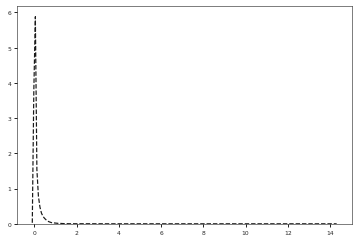

In [ ]:
sns.kdeplot(REP2_aa_freq['REP2_aa_freq'],
            alpha=.9,color='black', **{'linestyle':'dashed'})
#sns.histplot(ab_selection[0], color='blue')

plt.xlabel("")
plt.ylabel('')


In [ ]:
ab_selection = antibody_selection_df.mean(axis=1).apply(np.log2).dropna()
ab_selection = pd.DataFrame(ab_selection, columns=['log2ab'])
ab_selection.to_csv('ab_selection.txt', sep='\t')

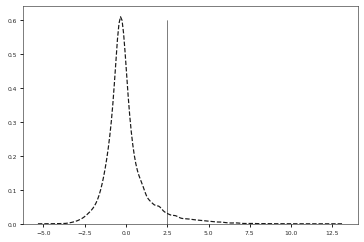

In [ ]:
sns.kdeplot(ab_selection[0],
            alpha=.9,color='black', **{'linestyle':'dashed'})
#sns.histplot(ab_selection[0], color='blue')

plt.xlabel("")
plt.ylabel('')
plt.plot([2.5,2.5],[0,0.6],c='black',lw=.5)

In [ ]:
a20_postions_subs = np.array([261,262,263,264,384,385,708,717,258,253,254,658,659,660,548,556])
ab_selection_a20binding = antibody_selection_df.loc[a20_postions_subs].mean(axis=1).apply(np.log2).dropna()
ab_selection_a20binding = pd.DataFrame(ab_selection_a20binding, columns=['log2ab'])
ab_selection_a20binding.to_csv('ab_selection_a20binding.txt', sep='\t')

mannwhitney test pval = 1.2760498469718762e-22
effect size: -1.3496786528656861


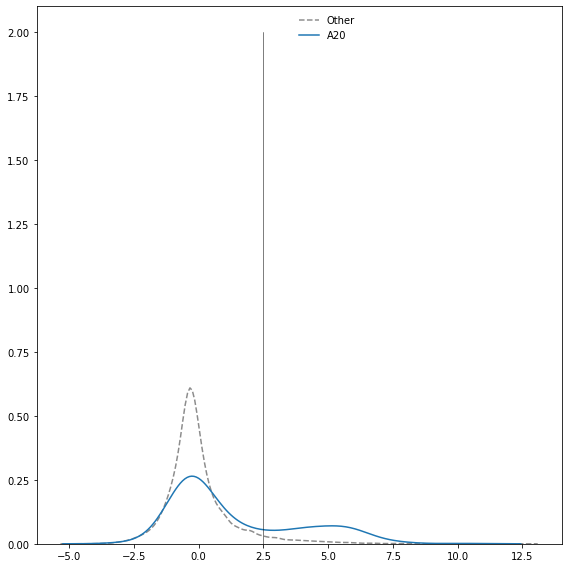

In [ ]:
a20_postions_subs = np.array([261,262,263,264,384,385,708,717,258,253,254,658,659,660,548,556])

def plot_a20_dist(ab_aa_df,
#                   hek_or_cre='HEK',
                  plot_wt_random = True,
                  plot_zoom=False,
                  legend_on=True,
                  figname=None, 
                  return_values=False):

    fig = plt.figure(figsize=[8,8])
    if plot_wt_random:
        wt = ab_aa_df.mean(axis=1).apply(np.log2).dropna()
        sns.kdeplot(ab_aa_df.mean(axis=1).apply(np.log2).dropna(), label='Other',
                    alpha=.9,color='gray', **{'linestyle':'dashed'})
        
    a20 = ab_aa_df.loc[a20_postions_subs].mean(axis=1).apply(np.log2).dropna()
    sns.kdeplot(ab_aa_df.loc[a20_postions_subs].mean(axis=1).apply(np.log2).dropna(), label='A20')
    
    print ('mannwhitney test pval = %s' % stats.mannwhitneyu(wt,a20)[1])
    print ('effect size: %s' % (wt.mean()- a20.mean()) )

    plt.xlabel("")
    plt.ylabel('')
    plt.plot([2.5,2.5],[0,2],c='black',lw=.5)

    if plot_zoom:
        plt.ylim([0,.5])
        plt.yticks([])
    if legend_on:
        plt.legend().set_visible(legend_on)
        plt.legend(bbox_to_anchor=(.4825,1),frameon=False)
    else:
        plt.legend().set_visible(legend_on)
    plt.tight_layout()
    if figname:
        figpath =  os.path.join(FIGURES_DIR, figname)
        save_fig(fig, figpath)
    if return_values:
        return wt, a20

wt, a20 = plot_a20_dist(antibody_selection_df,figname = None, return_values=True)

abs_pos  aa  wt_bc  lib_type
1.0      *   0      sub        -0.245449
         A   0      sub        -0.925022
         C   0      sub         0.000539
         D   0      sub        -1.439113
         E   0      sub        -0.434321
                                  ...   
735.5    S   0      ins         0.664228
         T   0      ins        -0.457935
         V   0      ins         0.681047
         W   0      ins        -0.990088
         Y   0      ins         0.061583
Length: 29541, dtype: float64